In [1]:
path = "../data/"
csvfile = "Age_Mix_Settlement_Experiment_Results_Fig3.csv"

#import pandas
import pandas as pd
# import matplotlib
import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline
df = pd.read_csv(path+csvfile)
print(df)
df.head()
df.info()

           Date Abbreviation         Species  #_coverslip  #_crawl  #_swim  \
0    16/05/2022       nbc_1d  NEG_CNTRL_1day            1        2      23   
1    16/05/2022       nbc_1d  NEG_CNTRL_1day            1        1      23   
2    16/05/2022       nbc_1d  NEG_CNTRL_1day            2        6      19   
3    16/05/2022       nbc_1d  NEG_CNTRL_1day            1        3      24   
4    16/05/2022       nbc_1d  NEG_CNTRL_1day            0        2      27   
..          ...          ...             ...          ...      ...     ...   
103  16/05/2022    Mix_10sp.  10_species_mix            8        7       7   
104  16/05/2022    Mix_10sp.  10_species_mix            8        8       7   
105  16/05/2022    Mix_10sp.  10_species_mix           10        7       8   
106  16/05/2022    Mix_10sp.  10_species_mix           10        7       6   
107  16/05/2022    Mix_10sp.  10_species_mix           10        7      10   

     #_dead  Time after induction (h)  Age (dpf)  
0         4 

In [2]:
# Create an additional column '%_settlement_total' after converting the existing '%_coverslip' column into a percentage of total larvae (assumed 30 larvae/sample).
#also same for 48h, and % alive as well.  
# create a new column
df['%_settlement_total'] = df['#_coverslip'] / 30 * 100
df['%_settlement_alive'] = (df['#_coverslip'] / (30 - df['#_dead'])) * 100
  
# Print the DataFrame after 
# addition of new column
print(df)
df.head()
df.info()

           Date Abbreviation         Species  #_coverslip  #_crawl  #_swim  \
0    16/05/2022       nbc_1d  NEG_CNTRL_1day            1        2      23   
1    16/05/2022       nbc_1d  NEG_CNTRL_1day            1        1      23   
2    16/05/2022       nbc_1d  NEG_CNTRL_1day            2        6      19   
3    16/05/2022       nbc_1d  NEG_CNTRL_1day            1        3      24   
4    16/05/2022       nbc_1d  NEG_CNTRL_1day            0        2      27   
..          ...          ...             ...          ...      ...     ...   
103  16/05/2022    Mix_10sp.  10_species_mix            8        7       7   
104  16/05/2022    Mix_10sp.  10_species_mix            8        8       7   
105  16/05/2022    Mix_10sp.  10_species_mix           10        7       8   
106  16/05/2022    Mix_10sp.  10_species_mix           10        7       6   
107  16/05/2022    Mix_10sp.  10_species_mix           10        7      10   

     #_dead  Time after induction (h)  Age (dpf)  %_settlement_

In [3]:
#make a subset of df where time=24 h after induction
subset24 = df.loc[df["Time after induction (h)"]==24]

#make a subset of df where time=48 h after induction
subset48 = df.loc[df["Time after induction (h)"]==48]

In [4]:
#Run a Shapiro-Wilks test on data to check distribution
#import libraries needed
import numpy as np
from scipy.stats import shapiro
from numpy.random import random

#Conduct the Shapiro-Wilk Test
shapiroresult24 = shapiro(subset24["%_settlement_alive"])
#The test rejects the hypothesis of normality when the p-value is less than or equal to 0.05. We can state with 95% confidence that the data does NOT fit the normal distribution.

#Conduct the Shapiro-Wilk Test
shapiroresult48 = shapiro(subset48["%_settlement_alive"])

print(shapiroresult24)
print(shapiroresult48)

ShapiroResult(statistic=0.963132381439209, pvalue=0.09521331638097763)
ShapiroResult(statistic=0.8972476124763489, pvalue=0.00022818069555796683)


In [5]:
#We want to know if each type fo biofilm used causes significantly more settlement than control, after 24 and 48h.
#We will do Mann-Whitney U rank test on each treatment vs control to check for p-value <0.05, at 24 and 48h.

from scipy import stats

#test subsetting the data correctly for 24h control and other treatments
print(df["%_settlement_alive"][(df['Time after induction (h)']==24) & (df['Species'] == "NEG_CNTRL_1day")])
print(np.unique(df['Species']))

#make a dictionary called 'p-values' and output into it the results of a Mann-Whitney U test on each treatment vs control, 24h
p_values= {}
ctrl_data = df["%_settlement_alive"][(df['Time after induction (h)']==24) & (df['Species'] == "NEG_CNTRL_1day")]
for treatment in np.unique(df['Species']):
    test_data = df["%_settlement_alive"][(df['Time after induction (h)']==24) & (df['Species'] == treatment)]
    print(treatment)
    res = stats.mannwhitneyu(ctrl_data, test_data)
    print(res)
    p_values[treatment] = res[1]

#make a dictionary called 'p-values48' and output into it the results of a Mann-Whitney U test on each treatment vs control, 48h
p_values48= {}
ctrl_data48 = df["%_settlement_alive"][(df['Time after induction (h)']==48) & (df['Species'] == "NEG_CNTRL_1day")]
for treatment in np.unique(df['Species']):
    test_data48 = df["%_settlement_alive"][(df['Time after induction (h)']==48) & (df['Species'] == treatment)]
    print(treatment)
    res48 = stats.mannwhitneyu(ctrl_data48, test_data48)
    print(res48)
    p_values48[treatment] = res48[1]
    
#combine the two dictionaries for 24 and 48h into one dictionary
def mergeDictionary(p_values, p_values48):
   dict_both = {**p_values, **p_values48}
   for key, value in dict_both.items():
       if key in p_values and key in p_values48:
               dict_both[key] = [value , p_values[key]]
   return dict_both

dict_both = mergeDictionary(p_values, p_values48)
print(dict_both)

#make a dataframe from this dictionary
MW_results = pd.DataFrame.from_dict(dict_both, orient='index',
                       columns=['24h p-value', '48h p-value'])
MW_results_sorted = MW_results.sort_values(by='48h p-value', ascending=False)
MWresults_html = MW_results_sorted.style.set_caption('Table S1. Mann-Whitney U rank test p-values for different cues vs negative control')

#Save to file
MW_results_sorted.to_csv("../output/SuppTable_for_fig3a.csv")
MWresults_html.to_html("../output/SuppTable_for_fig3a.html")


0     3.846154
1     4.000000
2     7.407407
3     3.571429
4     0.000000
5    10.714286
Name: %_settlement_alive, dtype: float64
['10_species_mix' '3_species_mix' '6_species_mix_settle'
 '6_species_mix_settle_grow' 'Achnanthes_brevipes_1day'
 'Grammatophora_marina_1day' 'Grammatophora_marina_1week'
 'Grammatophora_marina_2weeks' 'Grammatophora_marina_5weeks'
 'NEG_CNTRL_1day' 'NEG_CNTRL_5weeks']
10_species_mix
MannwhitneyuResult(statistic=0.0, pvalue=0.004998124765082457)
3_species_mix
MannwhitneyuResult(statistic=4.0, pvalue=0.025974025974025976)
6_species_mix_settle
MannwhitneyuResult(statistic=0.0, pvalue=0.0021645021645021645)
6_species_mix_settle_grow
MannwhitneyuResult(statistic=0.0, pvalue=0.0021645021645021645)
Achnanthes_brevipes_1day
MannwhitneyuResult(statistic=1.5, pvalue=0.010271837730705762)
Grammatophora_marina_1day
MannwhitneyuResult(statistic=2.0, pvalue=0.008658008658008658)
Grammatophora_marina_1week
MannwhitneyuResult(statistic=0.0, pvalue=0.023809523809523808)
Gr

In [6]:
#do Kruskal-Wallis Test to check if significant difference between different groups at timepoint 24hpf.. Shapiro-Wilks test suggests data is not normally distributed.
#We are interest in 'Abbreviation', We will compare the G. marina biofilms treated in different ways.
 
import scipy.stats as stats

kruskalgroup=stats.kruskal(subset24["%_settlement_alive"][subset24["Species"] == "NEG_CNTRL_1day"],
               subset24["%_settlement_alive"][subset24["Species"] == "NEG_CNTRL_5weeks"],
                subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_1day"],
                subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_1week"],
                subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_2weeks"],
                subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_5weeks"])
                           
print(kruskalgroup)

#perform Dunn's test using a Bonferonni correction for the p-values
import scikit_posthocs as sp

datagroup = [subset24["%_settlement_alive"][subset24["Species"] == "NEG_CNTRL_1day"], 
             subset24["%_settlement_alive"][subset24["Species"] == "NEG_CNTRL_5weeks"], 
             subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_1day"], 
             subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_1week"], 
             subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_2weeks"], 
             subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_5weeks"]]

p_values = sp.posthoc_dunn(datagroup, p_adjust = 'bonferroni')
print(p_values)

p_values < 0.01

#KruskalResult((statistic=15.678783921056462, pvalue=0.007823584368925156)
#results shows diatom age is important for settlement at 24h,
#but no specific age biofilm better than control or another



KruskalResult(statistic=15.678783921056462, pvalue=0.007823584368925156)
          1         2         3    4         5         6
1  1.000000  1.000000  0.410781  1.0  0.017182  0.047370
2  1.000000  1.000000  1.000000  1.0  0.488250  0.906511
3  0.410781  1.000000  1.000000  1.0  1.000000  1.000000
4  1.000000  1.000000  1.000000  1.0  1.000000  1.000000
5  0.017182  0.488250  1.000000  1.0  1.000000  1.000000
6  0.047370  0.906511  1.000000  1.0  1.000000  1.000000


,1,2,3,4,5,6
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False


In [7]:
#do Kruskal-Wallis Test to check if significant difference between different groups at timepoint 48hpf.. Shapiro-Wilks test suggests data is not normally distributed.
#We are interest in 'Species', First we will compare the different ages of G. marina biofilm. Then we will compare the
#different mixed vs single species groups.
import scipy.stats as stats

kruskalgroup48=stats.kruskal(subset48["%_settlement_alive"][subset48["Species"] == "NEG_CNTRL_1day"],
               subset48["%_settlement_alive"][subset48["Species"] == "NEG_CNTRL_5weeks"],
                subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_1day"],
                subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_1week"],
                subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_2weeks"],
                subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_5weeks"])
print(kruskalgroup48)

#perform Dunn's test using a Bonferonni correction for the p-values
import scikit_posthocs as sp

datagroup48 = [subset48["%_settlement_alive"][subset48["Species"] == "NEG_CNTRL_1day"], 
             subset48["%_settlement_alive"][subset48["Species"] == "NEG_CNTRL_5weeks"], 
             subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_1day"], 
             subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_1week"], 
             subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_2weeks"], 
             subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_5weeks"]]

p_values48 = sp.posthoc_dunn(datagroup48, p_adjust = 'bonferroni')
print(p_values48)

p_values48 < 0.01

#KruskalResult(statistic=19.642701525054473, pvalue=0.0014580718032961885)
#results shows diatom age is important for settlement at 24h,
#but only 2week old biofilm are significantly different than control083.


KruskalResult(statistic=19.642701525054473, pvalue=0.0014580718032961885)
          1         2         3         4         5         6
1  1.000000  1.000000  0.118434  0.380508  0.004133  0.025625
2  1.000000  1.000000  1.000000  1.000000  0.210499  0.646212
3  0.118434  1.000000  1.000000  1.000000  1.000000  1.000000
4  0.380508  1.000000  1.000000  1.000000  1.000000  1.000000
5  0.004133  0.210499  1.000000  1.000000  1.000000  1.000000
6  0.025625  0.646212  1.000000  1.000000  1.000000  1.000000


,1,2,3,4,5,6
1,False,False,False,False,True,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,True,False,False,False,False,False
6,False,False,False,False,False,False


In [8]:
#do Kruskal-Wallis Test to check if significant difference between different groups at timepoint 24hpf.. Shapiro-Wilks test suggests data is not normally distributed.
#We are interest in 'Species', Here we will compare the different mixed vs single species groups.
import scipy.stats as stats

kruskalgroup_mix=stats.kruskal(subset24["%_settlement_alive"][subset24["Species"] == "NEG_CNTRL_1day"],
               subset24["%_settlement_alive"][subset24["Species"] == "Achnanthes_brevipes_1day"],
                subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_1day"],
                subset24["%_settlement_alive"][subset24["Species"] == "3_species_mix"],
                subset24["%_settlement_alive"][subset24["Species"] == "6_species_mix_settle"],
                subset24["%_settlement_alive"][subset24["Species"] == "6_species_mix_settle_grow"],
                subset24["%_settlement_alive"][subset24["Species"] == "10_species_mix"])
print(kruskalgroup_mix)

#perform Dunn's test using a Bonferonni correction for the p-values
import scikit_posthocs as sp

datagroup_mix = [subset24["%_settlement_alive"][subset24["Species"] == "NEG_CNTRL_1day"], 
             subset24["%_settlement_alive"][subset24["Species"] == "Achnanthes_brevipes_1day"], 
             subset24["%_settlement_alive"][subset24["Species"] == "Grammatophora_marina_1day"], 
             subset24["%_settlement_alive"][subset24["Species"] == "3_species_mix"], 
             subset24["%_settlement_alive"][subset24["Species"] == "6_species_mix_settle"], 
             subset24["%_settlement_alive"][subset24["Species"] == "6_species_mix_settle_grow"],
            subset24["%_settlement_alive"][subset24["Species"] == "10_species_mix"]]

p_values_mix = sp.posthoc_dunn(datagroup_mix, p_adjust = 'bonferroni')
print(p_values_mix)

p_values_mix < 0.0083

#KruskalResult(statistic=18.74024340770792, pvalue=0.004625571161867118)
#results shows diatom species mix is important for settlement at 24h,
#but specific type biofilm are significantly different than others or controls.

KruskalResult(statistic=18.74024340770792, pvalue=0.004625571161867118)
          1         2         3    4         5         6         7
1  1.000000  0.758431  0.137258  1.0  0.021438  0.012864  0.014025
2  0.758431  1.000000  1.000000  1.0  1.000000  1.000000  1.000000
3  0.137258  1.000000  1.000000  1.0  1.000000  1.000000  1.000000
4  1.000000  1.000000  1.000000  1.0  1.000000  1.000000  1.000000
5  0.021438  1.000000  1.000000  1.0  1.000000  1.000000  1.000000
6  0.012864  1.000000  1.000000  1.0  1.000000  1.000000  1.000000
7  0.014025  1.000000  1.000000  1.0  1.000000  1.000000  1.000000


,1,2,3,4,5,6,7
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False


In [9]:
#do Kruskal-Wallis Test to check if significant difference between different groups at timepoint 48hpf.. Shapiro-Wilks test suggests data is not normally distributed.
#We are interest in 'Species', Here we will compare the different mixed vs single species groups.
import scipy.stats as stats

kruskalgroup_mix48=stats.kruskal(subset48["%_settlement_alive"][subset48["Species"] == "NEG_CNTRL_1day"],
               subset48["%_settlement_alive"][subset48["Species"] == "Achnanthes_brevipes_1day"],
                subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_1day"],
                subset48["%_settlement_alive"][subset48["Species"] == "3_species_mix"],
                subset48["%_settlement_alive"][subset48["Species"] == "6_species_mix_settle"],
                subset48["%_settlement_alive"][subset48["Species"] == "6_species_mix_settle_grow"],
                subset48["%_settlement_alive"][subset48["Species"] == "10_species_mix"])
print(kruskalgroup_mix)

#perform Dunn's test using a Bonferonni correction for the p-values
import scikit_posthocs as sp

datagroup_mix48 = [subset48["%_settlement_alive"][subset48["Species"] == "NEG_CNTRL_1day"], 
             subset48["%_settlement_alive"][subset48["Species"] == "Achnanthes_brevipes_1day"], 
             subset48["%_settlement_alive"][subset48["Species"] == "Grammatophora_marina_1day"], 
             subset48["%_settlement_alive"][subset48["Species"] == "3_species_mix"], 
             subset48["%_settlement_alive"][subset48["Species"] == "6_species_mix_settle"], 
             subset48["%_settlement_alive"][subset48["Species"] == "6_species_mix_settle_grow"],
            subset48["%_settlement_alive"][subset48["Species"] == "10_species_mix"]]

p_values_mix48 = sp.posthoc_dunn(datagroup_mix48, p_adjust = 'bonferroni')
print(p_values_mix48)

p_values_mix48 < 0.0083

#KruskalResult(statistic=18.74024340770792, pvalue=0.004625571161867118)
#results shows diatom species mix is important for settlement at 24h,
#in particular, type 2(A.brevipes), 4(3 species mix), and 6(10 species mix) are significantly different from control
#(but no treatments are significantly different from eachother) 

KruskalResult(statistic=18.74024340770792, pvalue=0.004625571161867118)
          1         2         3         4         5         6         7
1  1.000000  0.002049  1.000000  0.005520  0.038026  0.002049  1.000000
2  0.002049  1.000000  0.547783  1.000000  1.000000  1.000000  0.414936
3  1.000000  0.547783  1.000000  1.000000  1.000000  0.547783  1.000000
4  0.005520  1.000000  1.000000  1.000000  1.000000  1.000000  0.780976
5  0.038026  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
6  0.002049  1.000000  0.547783  1.000000  1.000000  1.000000  0.414936
7  1.000000  0.414936  1.000000  0.780976  1.000000  0.414936  1.000000


,1,2,3,4,5,6,7
1,False,True,False,True,False,True,False
2,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,True,False,False,False,False,False,False
7,False,False,False,False,False,False,False


In [10]:
#From the 24h dataset, use both the Mann-Whitney U rank test, and the median
#% settlement to generate an order of species ("Abbreviation") for the
#subsequent graphs that will be made for Figure 2.
#This will also allow us to generate a conditional colour palette for graphs, based on p-values
#of the Mann-Whitney U-rank test.

#make a dictionary called 'p-values' and output into it the results of a Mann-Whitney U test on each treatment vs control, 24h
p_values24_abb= {}
ctrl_data = df["%_settlement_alive"][(df['Time after induction (h)']==24) & (df['Abbreviation'] == "nbc_1d")]
for treatment in np.unique(df['Abbreviation']):
    test_data = df["%_settlement_alive"][(df['Time after induction (h)']==24) & (df['Abbreviation'] == treatment)]
    print(treatment)
    res = stats.mannwhitneyu(ctrl_data, test_data)
    print(res)
#Make sure the p-values are considered only up to 6 decimal places, so that p-values + median will make the
#correct ordering
    p_values24_abb[treatment] = round(res[1], 6)

print(p_values24_abb.keys())

#make a dataframe from this dictionary
#make a dataframe with median values for each 'Abbreviation' group (ie each species median % settlement)
median_vals = df[df["Time after induction (h)"] == 24].groupby("Abbreviation")["%_settlement_alive"].median()
#make a dataframe with 'Abbreviation', '24h p-value', 'Median' from % settlement alive at 24h data
dftest = pd.DataFrame(list(zip(p_values24_abb.keys(), p_values24_abb.values(), median_vals)),
                      columns =['Abbreviation', '24h p-value', 'Median'])
print(dftest)


#generate a colour palette to colour graphs depending on p-value of Mann Whitney U test at 24h % settlement             
custom_palette = []
for value in dftest['24h p-value']:
    if value < 0.005:
        custom_palette.append('steelblue')
    elif (value > 0.005) and (value < 0.05):
        custom_palette.append('lightblue')
    else:
        custom_palette.append('whitesmoke')
print(custom_palette)
print(dftest['Abbreviation'])

dictionary = dict(zip(dftest["Abbreviation"], custom_palette))
print(dictionary)

A.bre_1d
MannwhitneyuResult(statistic=1.5, pvalue=0.010271837730705762)
G.mar_1d
MannwhitneyuResult(statistic=2.0, pvalue=0.008658008658008658)
G.mar_1w
MannwhitneyuResult(statistic=0.0, pvalue=0.023809523809523808)
G.mar_2w
MannwhitneyuResult(statistic=0.0, pvalue=0.023809523809523808)
G.mar_5w
MannwhitneyuResult(statistic=0.0, pvalue=0.023809523809523808)
Mix_10sp.
MannwhitneyuResult(statistic=0.0, pvalue=0.004998124765082457)
Mix_3sp.
MannwhitneyuResult(statistic=4.0, pvalue=0.025974025974025976)
Mix_6spG
MannwhitneyuResult(statistic=0.0, pvalue=0.0021645021645021645)
Mix_6spS
MannwhitneyuResult(statistic=0.0, pvalue=0.0021645021645021645)
nbc_1d
MannwhitneyuResult(statistic=18.0, pvalue=1.0)
nbc_5w
MannwhitneyuResult(statistic=5.5, pvalue=0.4366607090489947)
dict_keys(['A.bre_1d', 'G.mar_1d', 'G.mar_1w', 'G.mar_2w', 'G.mar_5w', 'Mix_10sp.', 'Mix_3sp.', 'Mix_6spG', 'Mix_6spS', 'nbc_1d', 'nbc_5w'])
   Abbreviation  24h p-value     Median
0      A.bre_1d     0.010272  27.248677
1     

In [11]:
#From the 48h dataset, we will generate a conditional colour palette for graphs, based on p-values
#of the Mann-Whitney U-rank test.

#make a dictionary called 'p-values' and output into it the results of a Mann-Whitney U test on each treatment vs control, 48h
p_values48_abb= {}
ctrl_data48 = df["%_settlement_alive"][(df['Time after induction (h)']==48) & (df['Abbreviation'] == "nbc_1d")]
for treatment in np.unique(df['Abbreviation']):
    test_data48 = df["%_settlement_alive"][(df['Time after induction (h)']==48) & (df['Abbreviation'] == treatment)]
    print(treatment)
    res48 = stats.mannwhitneyu(ctrl_data48, test_data48)
    print(res48)
#Make sure the p-values are considered only up to 6 decimal places, so that p-values + median will make the
#correct ordering
    p_values48_abb[treatment] = round(res48[1], 6)

print(p_values48_abb.keys())

#make a dataframe from this dictionary
#make a dataframe with median values for each 'Abbreviation' group (ie each species median % settlement)
median_vals48 = df[df["Time after induction (h)"] == 48].groupby("Abbreviation")["%_settlement_alive"].median()
#make a dataframe with 'Abbreviation', '48h p-value', 'Median' from % settlement alive at 48h data
dftest48 = pd.DataFrame(list(zip(p_values48_abb.keys(), p_values48_abb.values(), median_vals48)),
                      columns =['Abbreviation', '48h p-value', 'Median'])
print(dftest48)


#generate a colour palette to colour graphs depending on p-value of Mann Whitney U test at 24h % settlement             
custom_palette48 = []
for value in dftest48['48h p-value']:
    if value < 0.005:
        custom_palette48.append('steelblue')
    elif (value > 0.005) and (value < 0.05):
        custom_palette48.append('lightblue')
    else:
        custom_palette48.append('whitesmoke')
print(custom_palette48)
print(dftest48['Abbreviation'])

dictionary48 = dict(zip(dftest48["Abbreviation"], custom_palette48))
print(dictionary48)

A.bre_1d
MannwhitneyuResult(statistic=0.0, pvalue=0.00492203567532315)
G.mar_1d
MannwhitneyuResult(statistic=0.0, pvalue=0.004998124765082457)
G.mar_1w
MannwhitneyuResult(statistic=0.0, pvalue=0.02753189387562954)
G.mar_2w
MannwhitneyuResult(statistic=0.0, pvalue=0.02753189387562954)
G.mar_5w
MannwhitneyuResult(statistic=0.0, pvalue=0.02753189387562954)
Mix_10sp.
MannwhitneyuResult(statistic=0.0, pvalue=0.004998124765082457)
Mix_3sp.
MannwhitneyuResult(statistic=0.0, pvalue=0.00492203567532315)
Mix_6spG
MannwhitneyuResult(statistic=0.0, pvalue=0.004998124765082457)
Mix_6spS
MannwhitneyuResult(statistic=0.0, pvalue=0.004998124765082457)
nbc_1d
MannwhitneyuResult(statistic=18.0, pvalue=1.0)
nbc_5w
MannwhitneyuResult(statistic=1.0, pvalue=0.048884633916181135)
dict_keys(['A.bre_1d', 'G.mar_1d', 'G.mar_1w', 'G.mar_2w', 'G.mar_5w', 'Mix_10sp.', 'Mix_3sp.', 'Mix_6spG', 'Mix_6spS', 'nbc_1d', 'nbc_5w'])
   Abbreviation  48h p-value     Median
0      A.bre_1d     0.004922  57.427536
1      G.ma

In [12]:
#Now we will also import the Growth at 11days data for the different biofilm types.
#So that we can plot it as a graph underneath the settlement graph #First needed to remove micron symbol from .csv file header name
df2 = pd.read_csv("../data/Age_Mix_Growth-11dpf_Experiments_Results_Fig3.csv")
print(df2)
df2.head()
df2.info()

           Date         Species  Length (um)  No. segments Abbreviation
0    16/05/2022  NEG_CNTRL_1day      353.506             3       nbc_1d
1    16/05/2022  NEG_CNTRL_1day      341.015             3       nbc_1d
2    16/05/2022  NEG_CNTRL_1day      305.506             3       nbc_1d
3    16/05/2022  NEG_CNTRL_1day      320.047             3       nbc_1d
4    16/05/2022  NEG_CNTRL_1day      310.022             3       nbc_1d
..          ...             ...          ...           ...          ...
317  16/05/2022  10_species_mix      518.843             4    Mix_10sp.
318  16/05/2022  10_species_mix      598.478             4    Mix_10sp.
319  16/05/2022  10_species_mix      493.161             4    Mix_10sp.
320  16/05/2022  10_species_mix      576.273             4    Mix_10sp.
321  16/05/2022  10_species_mix      585.926             4    Mix_10sp.

[322 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 5 columns):
 #   Col

In [13]:
#Conduct the Shapiro-Wilk Test to check if size data is normally distributed
shapiro(df2["Length (um)"])
#The test rejects the hypothesis of normality when the p-value is less than or equal to 0.05. We can state with 95% confidence that the data does NOT fit the normal distribution. 

ShapiroResult(statistic=0.9710277915000916, pvalue=4.6067752919043414e-06)

In [14]:
#We want to know if each species of microlgae used causes significantly more settlement than control, after 24 and 48h.
#We will do Mann-Whitney U rank test on each treatment vs control to check for p-value <0.05.


#make a dictionary called 'p-values' and output into it the results of a Mann-Whitney U test on each treatment vs control, 24h
p_valuesgrowth= {}
ctrl_data_growth = df2["Length (um)"][(df2['Abbreviation']=="nbc_1d")]

for treatment in np.unique(df2["Abbreviation"]):
    test_data_growth = df2["Length (um)"][(df2["Abbreviation"]==treatment)]
    print(treatment)
    res_growth = stats.mannwhitneyu(ctrl_data_growth, test_data_growth)
    print(res_growth)
    p_valuesgrowth[treatment] = res_growth[1]

#make a dataframe from this dictionary
growth_results = pd.DataFrame.from_dict(p_valuesgrowth, orient='index',
                       columns=['Growth 11days p-value'])
growth_results_sorted = growth_results.sort_values(by='Growth 11days p-value', ascending=False)
growth_results_html = growth_results_sorted.style.set_caption('Table S8. Mann-Whitney U rank test p-values for size at 11 days in response to different biofilm age and mix vs negative control')
growth_results_sorted.style
print(growth_results_sorted)

#Save to file
growth_results_sorted.to_csv("../output/SuppTable_for_fig3C.csv")
growth_results_html.to_html("../output/SuppTable_for_fig3C.html")

#The Bonferroni correction counteracts the family-wise error rate problem by adjusting the alpha value based on the number of tests. To find your adjusted significance level, divide the significance level (α) for a single test by the number of tests (n)
#Here, we adjust the p-value as 0.05/10=0.005

A.bre_1d
MannwhitneyuResult(statistic=0.0, pvalue=3.0463409828899006e-13)
G.mar_1d
MannwhitneyuResult(statistic=32.0, pvalue=4.151101629126084e-12)
G.mar_1w
MannwhitneyuResult(statistic=0.0, pvalue=2.9200704383118184e-09)
G.mar_2w
MannwhitneyuResult(statistic=2.0, pvalue=3.6497874499694444e-09)
G.mar_5w
MannwhitneyuResult(statistic=1.0, pvalue=3.265139702266194e-09)
Mix_10sp.
MannwhitneyuResult(statistic=0.0, pvalue=3.0463409828899006e-13)
Mix_3sp.
MannwhitneyuResult(statistic=0.0, pvalue=6.687894728730684e-13)
Mix_6spG
MannwhitneyuResult(statistic=0.0, pvalue=3.0463409828899006e-13)
Mix_6spS
MannwhitneyuResult(statistic=19.0, pvalue=1.4588192154314624e-12)
nbc_1d
MannwhitneyuResult(statistic=648.0, pvalue=1.0)
nbc_5w
MannwhitneyuResult(statistic=440.0, pvalue=0.03406045584392477)
           Growth 11days p-value
nbc_1d              1.000000e+00
nbc_5w              3.406046e-02
G.mar_2w            3.649787e-09
G.mar_5w            3.265140e-09
G.mar_1w            2.920070e-09
G.mar_1d  

In [15]:
#From the growth dataset, we will generate a conditional colour palette for graphs, based on p-values
#of the Mann-Whitney U-rank test.

#make a dictionary called 'p-values' and output into it the results of a Mann-Whitney U test on each treatment vs control, 48h
p_valuesgrowth_abb= {}
ctrl_data_g = df2["Length (um)"][(df2['Abbreviation'] == "nbc_1d")]
for treatment in np.unique(df2['Abbreviation']):
    test_data_g = df2["Length (um)"][(df2['Abbreviation'] == treatment)]
    print(treatment)
    resgrowth = stats.mannwhitneyu(ctrl_data_g, test_data_g)
    print(resgrowth)
#Make sure the p-values are considered only up to 6 decimal places, so that p-values + median will make the
#correct ordering
    p_valuesgrowth_abb[treatment] = round(resgrowth[1], 6)

print(p_valuesgrowth_abb.keys())

#make a dataframe from this dictionary
#make a dataframe with median values for each 'Abbreviation' group (ie each species median % settlement)
median_valsgrowth = df2.groupby("Abbreviation")["Length (um)"].median()
#make a dataframe with 'Abbreviation', 'growth p-value', 'Median' from length at 11d data
dftestgrowth = pd.DataFrame(list(zip(p_valuesgrowth_abb.keys(), p_valuesgrowth_abb.values(), median_valsgrowth)),
                      columns =['Abbreviation', 'Length p-value', 'Median'])
print(dftestgrowth)

#generate a colour palette to colour graphs depending on p-value of Mann Whitney U test at 24h % settlement             
custom_palette_growth = []
for value in dftestgrowth['Length p-value']:
    if value < 0.005:
        custom_palette_growth.append('steelblue')
    elif (value > 0.005) and (value < 0.05):
        custom_palette_growth.append('lightblue')
    else:
        custom_palette_growth.append('whitesmoke')
print(custom_palette_growth)
print(dftestgrowth['Abbreviation'])

dictionary_growth = dict(zip(dftestgrowth["Abbreviation"], custom_palette_growth))
print(dictionary_growth)

A.bre_1d
MannwhitneyuResult(statistic=0.0, pvalue=3.0463409828899006e-13)
G.mar_1d
MannwhitneyuResult(statistic=32.0, pvalue=4.151101629126084e-12)
G.mar_1w
MannwhitneyuResult(statistic=0.0, pvalue=2.9200704383118184e-09)
G.mar_2w
MannwhitneyuResult(statistic=2.0, pvalue=3.6497874499694444e-09)
G.mar_5w
MannwhitneyuResult(statistic=1.0, pvalue=3.265139702266194e-09)
Mix_10sp.
MannwhitneyuResult(statistic=0.0, pvalue=3.0463409828899006e-13)
Mix_3sp.
MannwhitneyuResult(statistic=0.0, pvalue=6.687894728730684e-13)
Mix_6spG
MannwhitneyuResult(statistic=0.0, pvalue=3.0463409828899006e-13)
Mix_6spS
MannwhitneyuResult(statistic=19.0, pvalue=1.4588192154314624e-12)
nbc_1d
MannwhitneyuResult(statistic=648.0, pvalue=1.0)
nbc_5w
MannwhitneyuResult(statistic=440.0, pvalue=0.03406045584392477)
dict_keys(['A.bre_1d', 'G.mar_1d', 'G.mar_1w', 'G.mar_2w', 'G.mar_5w', 'Mix_10sp.', 'Mix_3sp.', 'Mix_6spG', 'Mix_6spS', 'nbc_1d', 'nbc_5w'])
   Abbreviation  Length p-value    Median
0      A.bre_1d         0

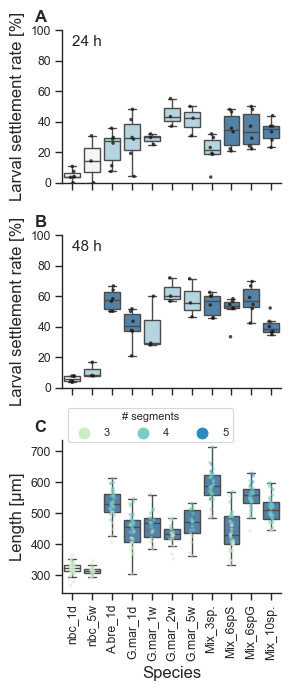

In [24]:
#Now we can make plots for % settlement alive at 24h and 48h,and length at 11 days.

#Order them by p-value+median % settlement at 24h
#newranks = dftest.sort_values(['24h p-value', 'Median'],
#              ascending = [False, True])

#Colour them according to p-value from Mann-Whitney U-test

fig, axes = plt.subplots(3, 1, figsize=(3, 7))
sns.set_style('ticks')
sns.despine()


#% settlement alive at 24h after induction
plot1 = sns.boxplot(ax=axes[0], data=subset24, x="Abbreviation", y="%_settlement_alive", 
                    #order=newranks["Abbreviation"], 
                    linewidth=1.0, 
                    #color="whitesmoke", 
                    fliersize=0, palette=dictionary)
plot1 = sns.stripplot(ax=axes[0], data=subset24, x='Abbreviation', y="%_settlement_alive", jitter=True, dodge=True, 
                      marker='o', alpha=0.8, size=2.5, 
                      #order=newranks["Abbreviation"], 
                      color="k")
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=90)
plot1.set_ylabel("Larval settlement rate [%]", fontsize=12)
plot1.set_ylim(0, 100)
plot1.set(xticklabels=[]) 
plot1.set(xlabel=None)
plot1.set_title('A', fontdict={'size': 12, 'weight': 'bold', 'name': 'Arial', 'position':(-0.1,0)})
plot1.text(0.0, 90,'24 h', fontsize=11) #add text

#% settlement alive at 48h after induction
plot2 = sns.boxplot(ax=axes[1], data=subset48, x="Abbreviation", y="%_settlement_alive", linewidth=1.0, fliersize=0, palette=dictionary48)
plot2 = sns.stripplot(ax=axes[1], data=subset48, x='Abbreviation', y="%_settlement_alive", jitter=True, dodge=True, marker='o', alpha=0.8, size=2.5, color="k")
plot2.set_ylabel("Larval settlement rate [%]", fontsize=12)
plot2.set_ylim(0, 100)
plot2.set(xticklabels=[])
plot2.set(xlabel=None)
plt.tight_layout()
plot2.set_title('B', fontdict={'size': 12, 'weight': 'bold', 'name': 'Arial', 'position':(-0.1,0)})
plot2.text(0.0, 90,'48 h', fontsize=11) #add text
#Length at 11d (8d after induction)

growthplot = sns.boxplot(ax=axes[2], data=df2,  
                         linewidth=1.0, x="Abbreviation", y="Length (um)", palette=dictionary_growth, 
                         fliersize=0)
growthplot = sns.stripplot(ax=axes[2], data=df2, 
                           x="Abbreviation", y="Length (um)", hue="No. segments", palette='GnBu', alpha=0.5, size=2.5)
growthplot.set_xticklabels(growthplot.get_xticklabels(), rotation=90)
growthplot.set_ylabel("Length [µm]", fontsize=12)
growthplot.set_xlabel("Species", fontsize=12)
growthplot.set_title('C', fontdict={'size': 12, 'weight': 'bold', 'name': 'Arial', 'position':(-0.1,0)})

#Position legend top left inside graph
sns.move_legend(growthplot, "lower left", bbox_to_anchor=(0, 0.95), ncol=3, title='# segments', frameon=True, fontsize=8, title_fontsize=8)


plt.tight_layout()


#Export graph to svg file
plt.savefig("../output/Figure3.svg", bbox_inches='tight')

In [17]:
#do Kruskal-Wallis Test to check if significant difference between different groups at size 11dpi Shapiro-Wilks test suggests data is not normally distributed.
#We are interested in 'Abbreviation'
import scipy.stats as stats

kruskalgroup_age=stats.kruskal(df2["Length (um)"][df2["Abbreviation"] == "nbc_1d"], 
                             df2["Length (um)"][df2["Abbreviation"] == "nbc_5w"], 
                             df2["Length (um)"][df2["Abbreviation"] == "G.mar_1d"], 
                             df2["Length (um)"][df2["Abbreviation"] == "G.mar_1w"], 
                             df2["Length (um)"][df2["Abbreviation"] == "G.mar_2w"], 
                             df2["Length (um)"][df2["Abbreviation"] == "G.mar_5w"])

kruskalgroup_mix=stats.kruskal(df2["Length (um)"][df2["Abbreviation"] == "nbc_1d"], 
                             df2["Length (um)"][df2["Abbreviation"] == "A.bre_1d"], 
                             df2["Length (um)"][df2["Abbreviation"] == "G.mar_1d"], 
                             df2["Length (um)"][df2["Abbreviation"] == "Mix_3sp."], 
                             df2["Length (um)"][df2["Abbreviation"] == "Mix_6spS"], 
                             df2["Length (um)"][df2["Abbreviation"] == "Mix_6spG"], 
                             df2["Length (um)"][df2["Abbreviation"] == "Mix_10sp."])
                             
                             
print(kruskalgroup_age)
print(kruskalgroup_mix)

#perform Dunn's test using a Bonferonni correction for the p-values
import scikit_posthocs as sp

datagroup_g = [df2["Length (um)"][df2["Abbreviation"] == "nbc_1d"], df2["Length (um)"][df2["Abbreviation"] == "nbc_5w"], 
               df2["Length (um)"][df2["Abbreviation"] == "A.bre_1d"], df2["Length (um)"][df2["Abbreviation"] == "G.mar_1d"], 
               df2["Length (um)"][df2["Abbreviation"] == "G.mar_1w"], df2["Length (um)"][df2["Abbreviation"] == "G.mar_2w"], 
               df2["Length (um)"][df2["Abbreviation"] == "G.mar_5w"], df2["Length (um)"][df2["Abbreviation"] == "Mix_3sp."], 
               df2["Length (um)"][df2["Abbreviation"] == "Mix_6spS"], df2["Length (um)"][df2["Abbreviation"] == "Mix_6spG"], 
               df2["Length (um)"][df2["Abbreviation"] == "Mix_10sp."]]
p_values_g = sp.posthoc_dunn(datagroup_g, p_adjust = 'bonferroni')
print(p_values_g)

p_values_g < 0.005
#KruskalResult_Age(statistic=99.51069604086854, pvalue=6.701565055929603e-20)
#KruskalResult_Mix(statistic=177.57655619192968, pvalue=1.1096957481070438e-35)
#results shows centric diatoms no different from control, but there is no preference towards any other single group.


KruskalResult(statistic=99.51069604086854, pvalue=6.701565055929603e-20)
KruskalResult(statistic=177.57655619192968, pvalue=1.1096957481070438e-35)
              1             2             3             4         5   \
1   1.000000e+00  1.000000e+00  4.959869e-17  5.003905e-04  0.002048   
2   1.000000e+00  1.000000e+00  1.583681e-12  3.430884e-03  0.005270   
3   4.959869e-17  1.583681e-12  1.000000e+00  5.709386e-04  0.106714   
4   5.003905e-04  3.430884e-03  5.709386e-04  1.000000e+00  1.000000   
5   2.047592e-03  5.270444e-03  1.067137e-01  1.000000e+00  1.000000   
6   1.932183e-01  2.350559e-01  9.209193e-04  1.000000e+00  1.000000   
7   8.096538e-04  2.458512e-03  2.115844e-01  1.000000e+00  1.000000   
8   7.197874e-27  1.396389e-19  9.603567e-01  9.824969e-10  0.000029   
9   1.762342e-03  8.775185e-03  1.515784e-04  1.000000e+00  1.000000   
10  6.211646e-22  5.715406e-16  1.000000e+00  1.234153e-06  0.002640   
11  2.157619e-13  5.921139e-10  1.000000e+00  3.446743e-02  

,1,2,3,4,5,6,7,8,9,10,11
1,False,False,True,True,True,False,True,True,True,True,True
2,False,False,True,True,False,False,True,True,False,True,True
3,True,True,False,True,False,True,False,False,True,False,False
4,True,True,True,False,False,False,False,True,False,True,False
5,True,False,False,False,False,False,False,True,False,True,False
6,False,False,True,False,False,False,False,True,False,True,False
7,True,True,False,False,False,False,False,True,False,False,False
8,True,True,False,True,True,True,True,False,True,False,False
9,True,False,True,False,False,False,False,True,False,True,False
10,True,True,False,True,True,True,False,False,True,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      108 non-null    object 
 1   Abbreviation              108 non-null    object 
 2   Species                   108 non-null    object 
 3   #_coverslip               108 non-null    int64  
 4   #_crawl                   108 non-null    int64  
 5   #_swim                    108 non-null    int64  
 6   #_dead                    108 non-null    int64  
 7   Time after induction (h)  108 non-null    int64  
 8   Age (dpf)                 108 non-null    int64  
 9   %_settlement_total        108 non-null    float64
 10  %_settlement_alive        108 non-null    float64
 11  %_dead                    108 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 10.2+ KB


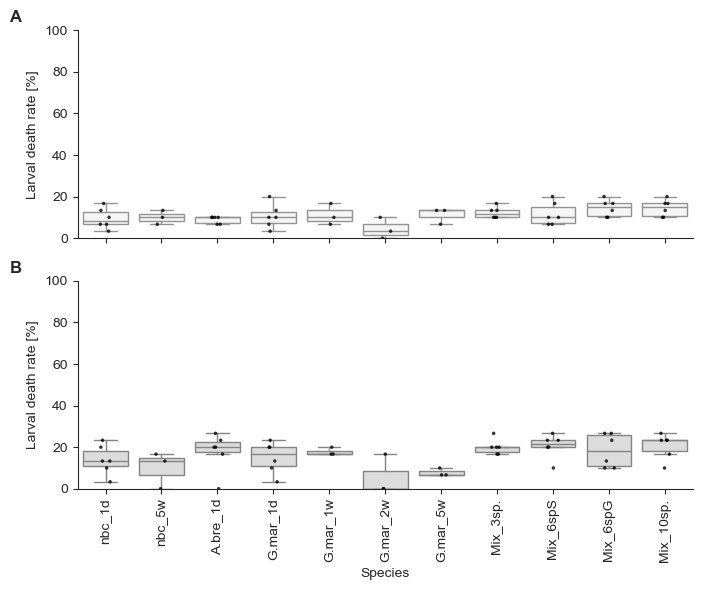

In [18]:
#Add a column to dataframe for % dead larvae and plot this across species
df['%_dead'] = df['#_dead'] / 30 * 100
df.info()

#Make a neutral palette
# color palette as dictionary
mypalette = {24:"whitesmoke", 48:"gainsboro"}

#Define specific properties of boxplot, so that lines and whiskers on boxes are black
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


#make a subset of df where time=24 h after induction
subset24 = df.loc[df["Time after induction (h)"]==24]

#make a subset of df where time=48 h after induction
subset48 = df.loc[df["Time after induction (h)"]==48]

#Try to plot the same data, but split the 24 & 48h data into two separate graphs, one on top of the other.
fig, axes = plt.subplots(2, 1, figsize=(7, 6))
sns.despine()


#% settlement alive at 24h after induction
plot1 = sns.boxplot(ax=axes[0], data=subset24, x="Abbreviation", y="%_dead", linewidth=1.0, color="whitesmoke", fliersize=0)
plot1 = sns.stripplot(ax=axes[0], data=subset24, x='Abbreviation', y="%_dead", jitter=True, dodge=True, marker='o', alpha=0.8, size=2.5, color="k")
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=90)
plot1.set_ylabel("Larval death rate [%]")
plot1.set_ylim(0, 100)
plot1.set(xticklabels=[]) 
plot1.set(xlabel=None)
plot1.set_title('A', fontdict={'size': 12, 'weight': 'bold', 'name': 'Arial', 'position':(-0.1,0)})

#% settlement alive at 48h after induction
plot2 = sns.boxplot(ax=axes[1], data=subset48, x="Abbreviation", y="%_dead", linewidth=1.0, color="gainsboro", fliersize=0)
plot2 = sns.stripplot(ax=axes[1], data=subset48, x='Abbreviation', y="%_dead", jitter=True, dodge=True, marker='o', alpha=0.8, size=2.5, color="k")
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=90)
plot2.set_ylabel("Larval death rate [%]")
plot2.set_ylim(0, 100)
plt.xlabel("Species")
plot2.set_title('B', fontdict={'size': 12, 'weight': 'bold', 'name': 'Arial', 'position':(-0.1,0)})
plt.tight_layout()

sns.set_theme(style="ticks")

#Export graph to an svg file for use in figure 
plt.savefig("../output/figS3a-supp.svg", bbox_inches='tight')

In [19]:
#We want to know if each type of biofilm used causes significantly more death than control, after 24 and 48h.
#We will do Mann-Whitney U rank test on each treatment vs control to check for p-value <0.05, at 24 and 48h.

from scipy import stats

#test subsetting the data correctly for 24h control and other treatments
print(df["%_dead"][(df['Time after induction (h)']==24) & (df['Species'] == "NEG_CNTRL_1day")])
print(np.unique(df['Species']))

#make a dictionary called 'p-values' and output into it the results of a Mann-Whitney U test on each treatment vs control, 24h
p_values_dead= {}
ctrl_data_dead = df["%_dead"][(df['Time after induction (h)']==24) & (df['Species'] == "NEG_CNTRL_1day")]
for treatment_dead in np.unique(df['Species']):
    test_data_dead = df["%_dead"][(df['Time after induction (h)']==24) & (df['Species'] == treatment_dead)]
    print(treatment_dead)
    res_dead = stats.mannwhitneyu(ctrl_data_dead, test_data_dead)
    print(res_dead)
    p_values_dead[treatment_dead] = res_dead[1]

#make a dictionary called 'p-values48' and output into it the results of a Mann-Whitney U test on each treatment vs control, 48h
p_values_dead48= {}
ctrl_data_dead48 = df["%_dead"][(df['Time after induction (h)']==48) & (df['Species'] == "NEG_CNTRL_1day")]
for treatment_dead48 in np.unique(df['Species']):
    test_data_dead48 = df["%_dead"][(df['Time after induction (h)']==48) & (df['Species'] == treatment_dead48)]
    print(treatment_dead48)
    res_dead48 = stats.mannwhitneyu(ctrl_data_dead48, test_data_dead48)
    print(res_dead48)
    p_values_dead48[treatment_dead48] = res_dead48[1]
    
#combine the two dictionaries for 24 and 48h into one dictionary
def mergeDictionary(p_values_dead, p_values_dead48):
   dict_both_dead = {**p_values_dead, **p_values_dead48}
   for key, value in dict_both_dead.items():
       if key in p_values_dead and key in p_values_dead48:
               dict_both_dead[key] = [value , p_values_dead[key]]
   return dict_both_dead

dict_both_dead = mergeDictionary(p_values_dead, p_values_dead48)
print(dict_both_dead)

#make a dataframe from this dictionary
MW_results_dead = pd.DataFrame.from_dict(dict_both_dead, orient='index',
                       columns=['24h p-value', '48h p-value'])
MW_results_dead_sorted = MW_results_dead.sort_values(by='48h p-value', ascending=False)
MWresults_dead_html = MW_results_dead_sorted.style.set_caption('Table S1. Mann-Whitney U rank test p-values for % death in different cues vs negative control')

#Export to file
MW_results_dead_sorted.to_csv("../output/Species-Specificity/SuppTable_for_figS3a.csv")
MWresults_dead_html.to_html("../output/SuppTable_for_figS3a.html")


0    13.333333
1    16.666667
2    10.000000
3     6.666667
4     3.333333
5     6.666667
Name: %_dead, dtype: float64
['10_species_mix' '3_species_mix' '6_species_mix_settle'
 '6_species_mix_settle_grow' 'Achnanthes_brevipes_1day'
 'Grammatophora_marina_1day' 'Grammatophora_marina_1week'
 'Grammatophora_marina_2weeks' 'Grammatophora_marina_5weeks'
 'NEG_CNTRL_1day' 'NEG_CNTRL_5weeks']
10_species_mix
MannwhitneyuResult(statistic=7.5, pvalue=0.1030947009127415)
3_species_mix
MannwhitneyuResult(statistic=11.0, pvalue=0.28406662328943666)
6_species_mix_settle
MannwhitneyuResult(statistic=13.5, pvalue=0.5105379701969994)
6_species_mix_settle_grow
MannwhitneyuResult(statistic=7.5, pvalue=0.1030947009127415)
Achnanthes_brevipes_1day
MannwhitneyuResult(statistic=18.0, pvalue=1.0)
Grammatophora_marina_1day
MannwhitneyuResult(statistic=16.0, pvalue=0.8068398667404373)
Grammatophora_marina_1week
MannwhitneyuResult(statistic=7.0, pvalue=0.6911022238448428)
Grammatophora_marina_2weeks
Mannwhitneyu

          Date                      Species  diatom_%area Abbreviation  Group
0   16/05/2022               NEG_CNTRL_1day         0.032       nbc_1d    nbc
1   16/05/2022               NEG_CNTRL_1day         0.051       nbc_1d    nbc
2   16/05/2022               NEG_CNTRL_1day         0.027       nbc_1d    nbc
3   16/05/2022             NEG_CNTRL_5weeks         0.029       nbc_5w    nbc
4   16/05/2022             NEG_CNTRL_5weeks         0.074       nbc_5w    nbc
5   16/05/2022             NEG_CNTRL_5weeks         0.026       nbc_5w    nbc
6   16/05/2022     Achnanthes_brevipes_1day        22.543     A.bre_1d  A.bre
7   16/05/2022     Achnanthes_brevipes_1day        32.652     A.bre_1d  A.bre
8   16/05/2022     Achnanthes_brevipes_1day        35.806     A.bre_1d  A.bre
9   16/05/2022    Grammatophora_marina_1day         3.368     G.mar_1d  G.mar
10  16/05/2022    Grammatophora_marina_1day         5.593     G.mar_1d  G.mar
11  16/05/2022    Grammatophora_marina_1day         6.230     G.

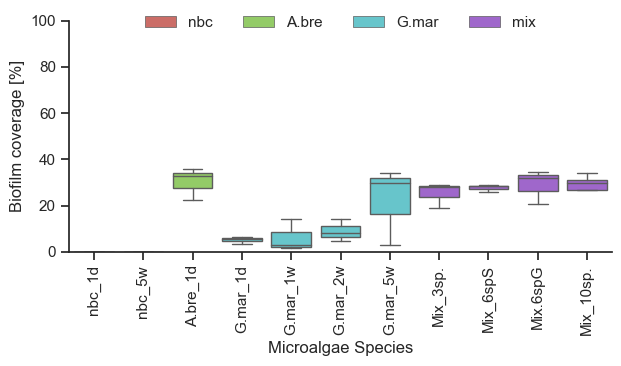

In [20]:
#Plot algal biofilm density according to species, for supplementary figure

#import biofilm density data
df3 = pd.read_csv("../data/Age_Mix_Settlement_Experiment_biofilm_density_Fig3.csv")
print(df3)
df3.head()
df3.info()

plt.figure(figsize=(7,3))
ax=sns.boxplot(data=df3, x="Abbreviation", y="diatom_%area", hue="Group", linewidth=1, palette="hls", dodge=False, fliersize=0)

#put legend above chart, unbound
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 0.9), ncol=4, title=None, frameon=False,
)
sns.set_style('ticks')
sns.despine()
sns.set_context('paper', font_scale = 1)
plt.xticks(rotation=90)
plt.xlabel("Microalgae Species")
plt.ylabel("Biofilm coverage [%]")
#Make y-axis range 0 to 100
ax.set_ylim(0, 100)

#Export graph to an svg file for use in figure 
plt.savefig("../output/SuppFig3b.svg", bbox_inches='tight')

In [21]:
#make a dataframe with median values for each 'Abbreviation' group (ie each species median % settlement)
median_vals24 = df[df["Time after induction (h)"] == 24].groupby("Abbreviation")["%_settlement_alive"].median()
list_median_vals24 = median_vals24.tolist()


median_vals48 = df[df["Time after induction (h)"] == 48].groupby("Abbreviation")["%_settlement_alive"].median()
list_median_vals48 = median_vals48.tolist()


median_biofilm=df3.groupby("Abbreviation")["diatom_%area"].median()

list_median_biofilm = median_biofilm.tolist()


names = ("A.bre_1d", "G.mar_1d", "G.mar_1w", "G.mar_2w", "G.mar_5w", "Mix_10sp.", "Mix_3sp.", "Mix_6spG", "Mix_6spS", "nbc_1d", "nbc_5w")


medians = pd.DataFrame(
    {'Abbreviation': names,
     'Median_%_settlement_24h': list_median_vals24,
     'Median_%_settlement_48h': list_median_vals48,
     'Median_%_biofilm': median_biofilm
    })
print(medians)


             Abbreviation  Median_%_settlement_24h  Median_%_settlement_48h  \
Abbreviation                                                                  
A.bre_1d         A.bre_1d                27.248677                57.427536   
G.mar_1d         G.mar_1d                29.100529                40.489130   
G.mar_1w         G.mar_1w                29.629630                29.166667   
G.mar_2w         G.mar_2w                43.333333                60.000000   
G.mar_5w         G.mar_5w                42.307692                55.555556   
Mix.6spG        Mix_10sp.                35.185185                38.518519   
Mix_10sp.        Mix_3sp.                21.153846                57.083333   
Mix_3sp.         Mix_6spG                33.101852                56.818182   
Mix_6spS         Mix_6spS                34.523810                53.359684   
nbc_1d             nbc_1d                 3.923077                 5.877617   
nbc_5w             nbc_5w                14.285714  

In [22]:
#For checking correlation of algal density to % settlement, we should use a data subset that excludes the no biofilm control measurements (nbc)

# Filter all rows of dataframe 'medians' for which the median % biofilm is >1%
df_filtered = medians[medians['Median_%_biofilm'] > 1]
 # Print the new dataframe
print(df_filtered.head())
 # Print the shape of the dataframe
print(df_filtered.shape)

#Check correlation between % larval settlement and % algal density with Pearson correlation test.

import numpy as np
import scipy.stats

#Run a Kendall's tau correlation test, a non-parametric test.           
tau24 = scipy.stats.kendalltau(df_filtered["Median_%_settlement_24h"], df_filtered["Median_%_biofilm"])  
print(tau24)
# Kendall's tau statistic==-0.05555555555555555, pvalue=0.919455467372134

tau48 = scipy.stats.kendalltau(df_filtered["Median_%_settlement_48h"], df_filtered["Median_%_biofilm"])  
print(tau48)
# Kendall's tau statistic=0.2777777777777778, pvalue=0.35848765432098767

#Result: there is no significant correlation between biofilm density and % larval settlement at 24 or 48h for different
#ages or mixtures of biofilm.

             Abbreviation  Median_%_settlement_24h  Median_%_settlement_48h  \
Abbreviation                                                                  
A.bre_1d         A.bre_1d                27.248677                57.427536   
G.mar_1d         G.mar_1d                29.100529                40.489130   
G.mar_1w         G.mar_1w                29.629630                29.166667   
G.mar_2w         G.mar_2w                43.333333                60.000000   
G.mar_5w         G.mar_5w                42.307692                55.555556   

              Median_%_biofilm  
Abbreviation                    
A.bre_1d                32.652  
G.mar_1d                 5.593  
G.mar_1w                 2.708  
G.mar_2w                 7.922  
G.mar_5w                29.835  
(9, 4)
SignificanceResult(statistic=-0.05555555555555555, pvalue=0.919455467372134)
SignificanceResult(statistic=0.2777777777777778, pvalue=0.35848765432098767)
